In [2]:
import pandas as pd #reading dataset
import matplotlib as mpl    #plotting, visualization
import matplotlib.pyplot as plt
import tensorflow as tf #building model
from tensorflow.keras.models import Model
import numpy as np  #playing output with model
from sklearn.model_selection import train_test_split    #model selection and scaling data
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

import sys
sys.path.append('../../')   # Add parent directory to Python path
from utils.Plots import *


In [ ]:
df = pd.read_csv('../../data/handlebar/Accelerometer_data_combined.csv')
# 0 for normal, 1 for abnormal
df['curb_scene'].value_counts()
df.drop('Unnamed: 0', axis=1, inplace=True)
df['NTP'] = pd.to_datetime(df['NTP'])
df_test = df[df['NTP'] > '2024-07-24 11:03:00']
df_train = df[df['NTP'] <= '2024-07-24 11:03:00']
df_train.shape, df_test.shape

((364816, 12), (101160, 12))

In [7]:
# plot_accelerometer_data(df_train, 'Handlebar Accelerometer Data Train')
# plot_accelerometer_data(df_test, 'Handlebar Accelerometer Data Test')

In [10]:
#Select important feature from train and test data
df_train_filtered = df_train[['Acc-Z','curb_scene']]
df_test_filtered = df_test[['Acc-Z','curb_scene']]
df_train_filtered_normal = df_train_filtered[df_train_filtered['curb_scene'] == 0]
df_train_filtered_abnormal = df_train_filtered[df_train_filtered['curb_scene'] == 1]
df_train_filtered_normal.shape,df_train_filtered_abnormal.shape

((351158, 2), (13658, 2))

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(df_train_filtered_normal[['Acc-Z']])
df_train_filtered['Acc-Z'] = scaler.transform(df_train_filtered[['Acc-Z']])
df_train_filtered_normal['Acc-Z'] = scaler.transform(df_train_filtered_normal[['Acc-Z']])
df_train_filtered_abnormal['Acc-Z'] = scaler.transform(df_train_filtered_abnormal[['Acc-Z']])
df_test_filtered['Acc-Z'] = scaler.transform(df_test_filtered[['Acc-Z']])
#sort the data
df_train_filtered_normal.sort_index(inplace=True)
df_train_filtered_abnormal.sort_index(inplace=True)

C:\Users\liuzi\AppData\Local\Temp\ipykernel_8320\3616157612.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_filtered_normal['Acc-Z'] = scaler.transform(df_train_filtered_normal[['Acc-Z']])
C:\Users\liuzi\AppData\Local\Temp\ipykernel_8320\3616157612.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_filtered_abnormal['Acc-Z'] = scaler.transform(df_train_filtered_abnormal[['Acc-Z']])
C:\Users\liuzi\AppData\Local\Temp\ipykernel_8320\3616157612.py:6: SettingWithCopyWarning: 
A value is tr

In [17]:
def to_sequences(x, seq_size=1):
    x_values = []

    for i in range(0, len(x)-seq_size, seq_size):
        #print(i)
        #sequence of values
        x_values.append(x.iloc[i:(i+seq_size)].values)

    return np.array(x_values)

In [ ]:
seq_size= 100
trainX_normal = to_sequences(df_train_filtered_normal['Acc-Z'],seq_size)
trainX_abnormal = to_sequences(df_train_filtered_abnormal['Acc-Z'],seq_size)
trainX_normal.shape, trainX_abnormal.shape
test_normal = to_sequences(df_test_filtered[df_test_filtered['curb_scene'] == 0]['Acc

((3511, 100), (136, 100))

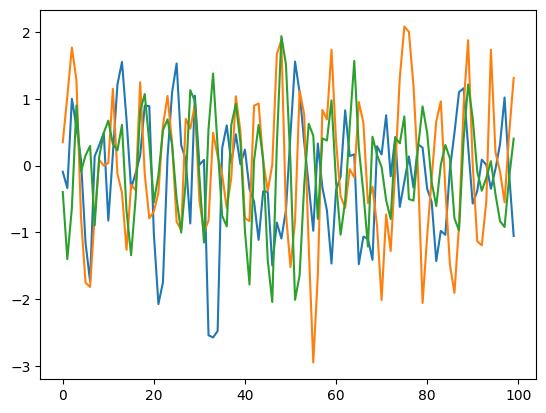

In [28]:
#See normal data ecg
plt.plot(trainX_normal[1000])
plt.plot(trainX_normal[500])
plt.plot(trainX_normal[2000])

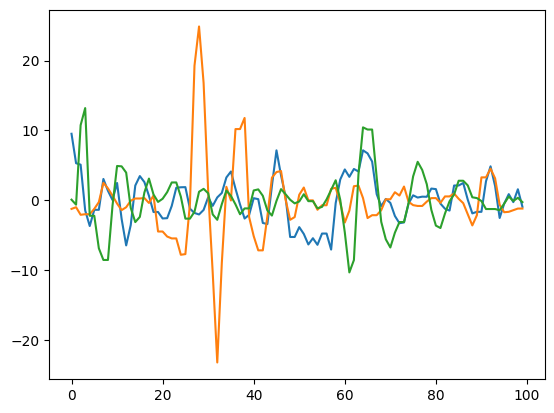

In [31]:
# #see abnormal data
plt.plot(trainX_abnormal[100])
plt.plot(trainX_abnormal[20])
plt.plot(trainX_abnormal[30])


In [42]:
#Allow me to use data in different ways
class AutoEncoder(Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='tanh'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(32, activation='tanh'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(16, activation='tanh'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(8, activation='tanh')
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(16, activation='tanh'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(32, activation='tanh'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(64, activation='tanh'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(100, activation='tanh')
        ])
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        #returns me a decoder object
        return decoded
    

In [43]:
#define model
model = AutoEncoder()
#if in 2 Epochs, loss is not decreasing, stop the training
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min')
model.compile(optimizer='adam', loss='mse')

In [44]:
# seprate class as well for normal and abnormal data invalidation data
history = model.fit(trainX_normal, trainX_normal,epochs=100, batch_size=128,
                    validation_split=0.1, 
                    shuffle=False, callbacks=[early_stopping])

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.8410 - val_loss: 1.3822
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7580 - val_loss: 1.2998
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7062 - val_loss: 1.2539
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6767 - val_loss: 1.2286
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6581 - val_loss: 1.2105
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6420 - val_loss: 1.1928
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6270 - val_loss: 1.1768
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6147 - val_loss: 1.1643
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6045 - val_loss: 1.1528
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5950 - val_loss: 1.1405
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5858 - val_loss: 1.1288
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5

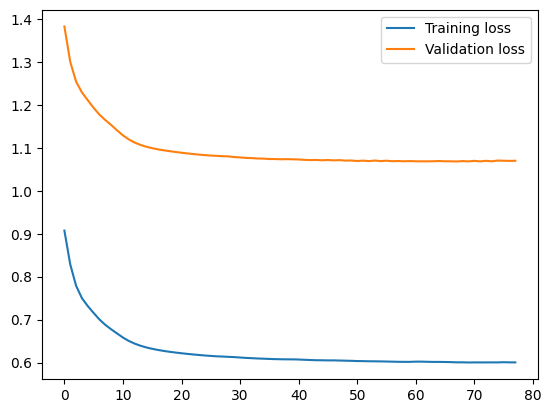

In [45]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()